In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the dataset

In [2]:
x_train = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/x_train_clean2.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/x_test_clean2.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/y_test.csv')

In [40]:
train = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/train_full.csv')
y = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/y_train_full.csv')
test = pd.read_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/test_full.csv')

In [3]:
y_test1 = y_test["y"]
y_train1 = y_train["y"]

In [4]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.5 MB/s eta 0:00:00


In [6]:
import shap

In [7]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.6 MB/s eta 0:00:00


Getter function for adjusted R-squared

In [8]:
def adj_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - n_features - 1)
    return adj_r2

Getter function for sample_submission csv submission

In [57]:
def create_sample_sub(model, train, test, y, x_train):
  # Predict on the validation data
  model_y_pred = model.predict(test[x_train.columns])
  # Create a new DataFrame
  df_new = pd.DataFrame()
  df_new['ID'] = test['ID']
  df_new['y'] = model_y_pred
  return df_new

1) Random Forest Baseline

In [37]:
print("--------Random Forest_CV--------")

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_regressor, x_train, y_train["y"], cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(rf_regressor, x_train, y_train["y"], cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------Random Forest_CV--------
CV RMSE scores: [8.29877831 7.63428493 7.83989284 7.21658297 8.1597035 ]
Mean RMSE: 7.8298485118871515
Std RMSE: 0.3855230463458499
CV R^2 scores: [0.56824872 0.60317566 0.60333276 0.63253422 0.58552114]
Mean R^2: 0.5985625012794504
Std R^2: 0.021387458380973213


In [9]:
print("--------RF--------")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# create and fit the model
start_time = time.time()
rf_reg = RandomForestRegressor(n_estimators=500, random_state=42,
                               max_depth = 3, min_samples_split = 600,
                               min_samples_leaf = 20)
end_time = time.time()
rf_reg.fit(x_train, y_train1)

# predict on the test set
y_pred = rf_reg.predict(x_test)

# evaluate the model using mean squared error
mse = mean_squared_error(y_test1, y_pred)

# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test, y_pred, x_test.shape[1])
print('Training time: {:.5} seconds'.format(end_time - start_time))
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------RF--------
Training time: 0.00023389 seconds
Mean Squared Error: 93.10371283038526
Adjusted R^2: 0.47253171190437404


Feature Importance for the Random Forest

   Feature  Importance
1     X314    0.650332
0     X127    0.113603
13    X118    0.055057
12    X119    0.048632
3     X136    0.035256
4     X263    0.034366
9     X232    0.016660
5      X29    0.012580
6     X279    0.011421
8      X54    0.011272


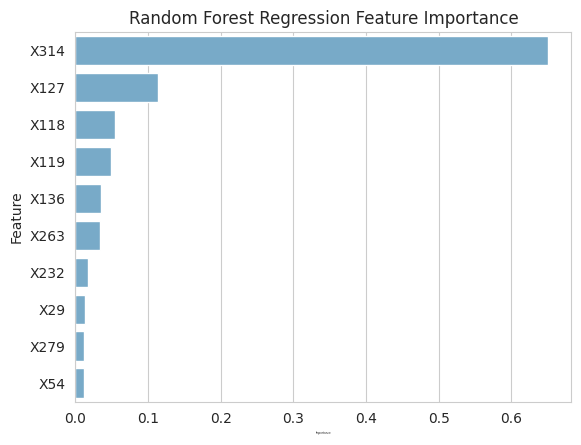

In [10]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = rf_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('Random Forest Regression Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for the Random Forest

Permutation explainer: 201it [03:40,  1.13s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


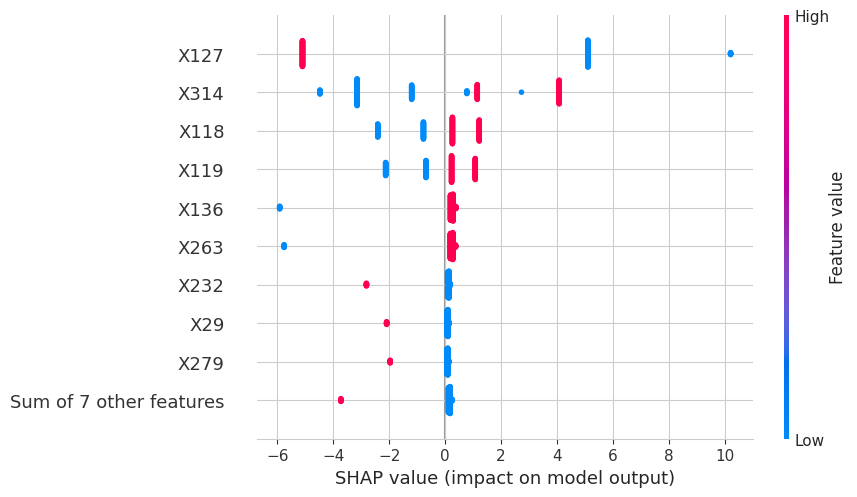

In [11]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(rf_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

In [58]:
# Fit the model on the training data
rf_reg.fit(train[x_train.columns], y["y"])
rf_df = create_sample_sub(rf_reg, train, test, y, x_train)
rf_df.head(n = 5)

,ID,y
0,1,77.949066
1,2,94.131878
2,3,77.949066
3,4,77.949066
4,5,112.923191


2) LGBM

In [35]:
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
print("--------LGBM_CV--------")
# Define a custom scoring function to calculate adjusted R-squared
def adj_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    adj_r2 = adj_r2_score(y, y_pred, X.shape[1])
    return adj_r2

# Create a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(lgb_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(lgb_regressor, x_train, y_train, cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------LGBM_CV--------
CV RMSE scores: [8.29587771 7.64086586 7.84209462 7.21697521 8.16024192]
Mean RMSE: 7.8312110648710656
Std RMSE: 0.3841384721414124
CV R^2 scores: [0.56855048 0.60249122 0.60310993 0.63249428 0.58546644]
Mean R^2: 0.5984224694502478
Std R^2: 0.021258454631448893


In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X127    2946 non-null   int64
 1   X314    2946 non-null   int64
 2   X261    2946 non-null   int64
 3   X136    2946 non-null   int64
 4   X263    2946 non-null   int64
 5   X29     2946 non-null   int64
 6   X279    2946 non-null   int64
 7   X76     2946 non-null   int64
 8   X54     2946 non-null   int64
 9   X232    2946 non-null   int64
 10  X313    2946 non-null   int64
 11  X0_az   2946 non-null   int64
 12  X119    2946 non-null   int64
 13  X118    2946 non-null   int64
 14  X328    2946 non-null   int64
 15  X162    2946 non-null   int64
dtypes: int64(16)
memory usage: 368.4 KB


In [13]:
print("--------LGBM--------")
import lightgbm as lgb
# Create a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(random_state = 42)
cat_features_index = list(range(x_train.shape[1]))
# Train the regressor
start_time = time.time()
lgb_regressor.fit(x_train, y_train,categorical_feature=cat_features_index)
end_time = time.time()
# Make predictions on the test data
y_pred1 = lgb_regressor.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred1)

# Calculate the R^2
r2 = r2_score(y_test1, y_pred1)

# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred1, x_test.shape[1])
print('Training time: {:.5} seconds'.format(end_time - start_time))
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------LGBM--------
Training time: 0.080671 seconds
Mean Squared Error: 97.20254103661338
Adjusted R^2: 0.4493102760302117


Using categorical_feature in Dataset.


Feature Importance for LGBM

   Feature  Importance
10    X313         195
12    X119         182
0     X127         121
1     X314         113
2     X261         100
3     X136          57
15    X162          32
4     X263           0
5      X29           0
6     X279           0


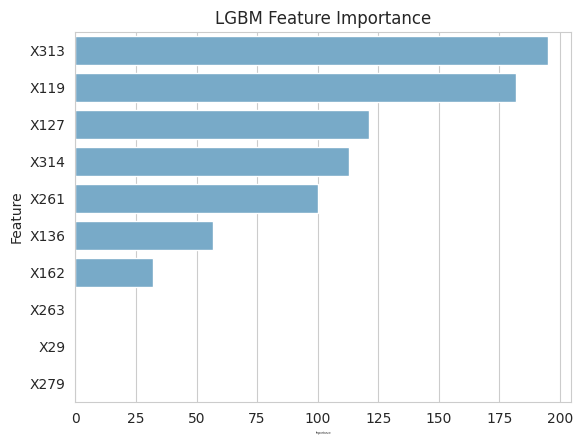

In [14]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = lgb_regressor.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('LGBM Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot for LGBM

Permutation explainer: 201it [00:17,  4.66it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


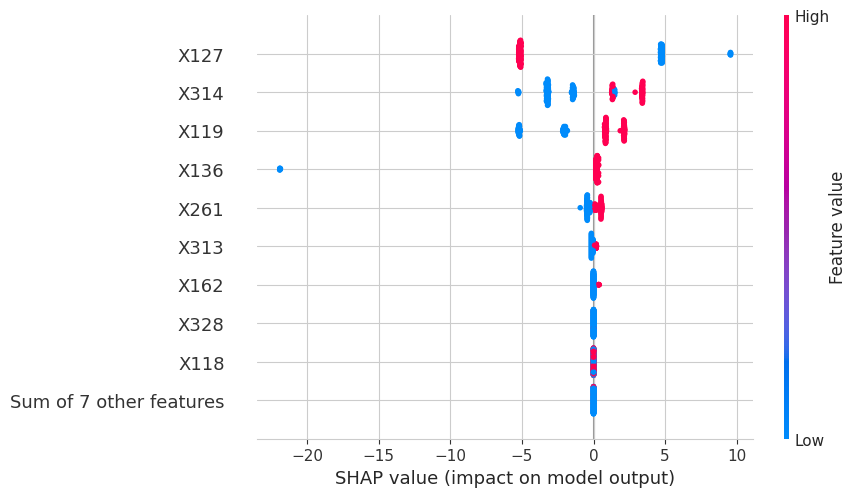

In [15]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(lgb_regressor.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

In [60]:
# Fit the model on the training data
lgb_regressor.fit(train[x_train.columns], y["y"],
                  categorical_feature=cat_features_index)
lgb_df = create_sample_sub(lgb_regressor, train, test, y, x_train)
lgb_df.head(n = 5)

Using categorical_feature in Dataset.


,ID,y
0,1,78.161994
1,2,93.958234
2,3,78.161994
3,4,78.161994
4,5,112.904975


3) XGBOOST

In [41]:
import xgboost as xgb
print("--------XGBoost_CV--------")

# Create an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(random_state=42, verbosity=0)

# Perform cross-validation
cv_scores = cross_val_score(xgb_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(xgb_regressor, x_train, y_train, cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------XGBoost_CV--------
CV RMSE scores: [8.29509796 7.62705085 7.84144893 7.21623712 8.1599185 ]
Mean RMSE: 7.827950670569405
Std RMSE: 0.3855296719924969
CV R^2 scores: [0.56863158 0.60392735 0.60317528 0.63256944 0.5854993 ]
Mean R^2: 0.5987605912121783
Std R^2: 0.021320611654125927


In [22]:
import xgboost as xgb
print("--------XGBoost--------")
# Instantiate an XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state = 42)
start_time = time.time()
# Train the model on the training data
xgb_reg.fit(x_train, y_train)
end_time = time.time()
# Predict the target values for the test data
y_pred2 = xgb_reg.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred2)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred2, x_test.shape[1])
print('Training time: {:.5} seconds'.format(end_time - start_time))
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------XGBoost--------
Training time: 0.16396 seconds
Mean Squared Error: 97.85376903438156
Adjusted R^2: 0.4456208193297201


Feature Importance for XGBoost

   Feature  Importance
1     X314    0.523436
12    X119    0.263427
3     X136    0.171870
0     X127    0.041268
2     X261    0.000000
4     X263    0.000000
5      X29    0.000000
6     X279    0.000000
7      X76    0.000000
8      X54    0.000000


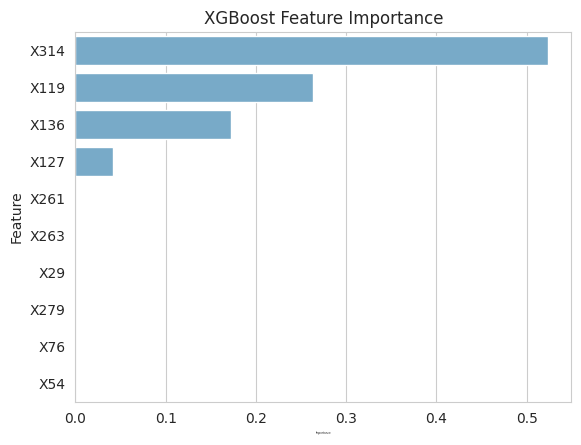

In [17]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = xgb_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for XGBoost

Permutation explainer: 201it [00:11,  3.25it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


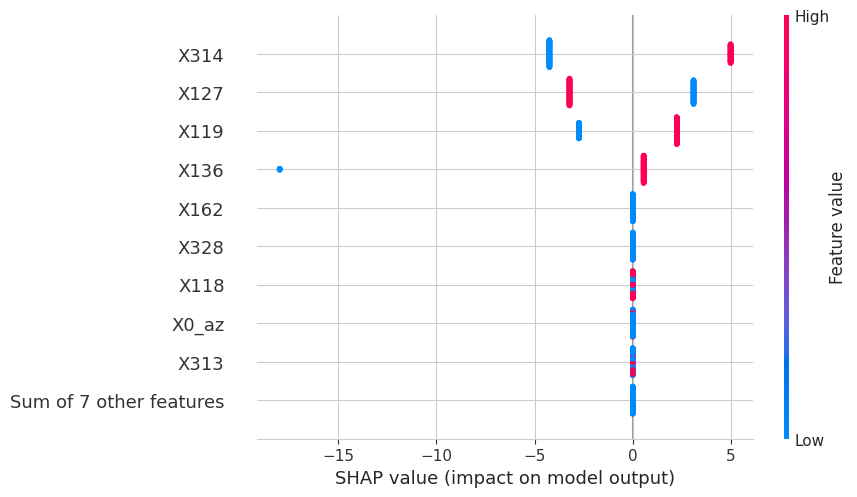

In [18]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(xgb_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

In [61]:
# Fit the model on the training data
xgb_reg.fit(train[x_train.columns], y["y"])
xgb_df = create_sample_sub(xgb_reg, train, test, y, x_train)
xgb_df.head(n = 5)

,ID,y
0,1,78.038422
1,2,93.958076
2,3,78.038422
3,4,78.038422
4,5,112.905273


4) Catboost

In [38]:
print("--------CatBoost_CV--------")

# Create a CatBoost regressor
catboost_regressor = CatBoostRegressor(random_state=42, verbose=False)

# Perform cross-validation
cv_scores = cross_val_score(catboost_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(catboost_regressor, x_train, y_train, cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------CatBoost_CV--------
CV RMSE scores: [8.29511071 7.62806365 7.84149057 7.21620112 8.15991763]
Mean RMSE: 7.828156735719415
Std RMSE: 0.3854389741260614
CV R^2 scores: [0.56863025 0.60382215 0.60317107 0.63257311 0.58549939]
Mean R^2: 0.5987391945958793
Std R^2: 0.02131690590531914


In [46]:
from catboost import CatBoostRegressor
print("--------CatBoost--------")

# Initialize the CatBoostRegressor model
cat_reg = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6,
                            random_seed=42, loss_function='RMSE')

# Fit the model on the training data
cat_reg.fit(x_train, y_train1, verbose = False)

# Predict on the validation data
y_pred4 = cat_reg.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred4)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred4, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------CatBoost--------
Mean Squared Error: 94.41465980619253
Adjusted R^2: 0.46510469383933795


Feature importance for CatBoost

   Feature  Importance
0     X127   37.979619
12    X119   20.647282
1     X314   15.721738
13    X118   13.612880
8      X54    6.210671
7      X76    2.423425
4     X263    0.898795
2     X261    0.898778
5      X29    0.692293
3     X136    0.244842


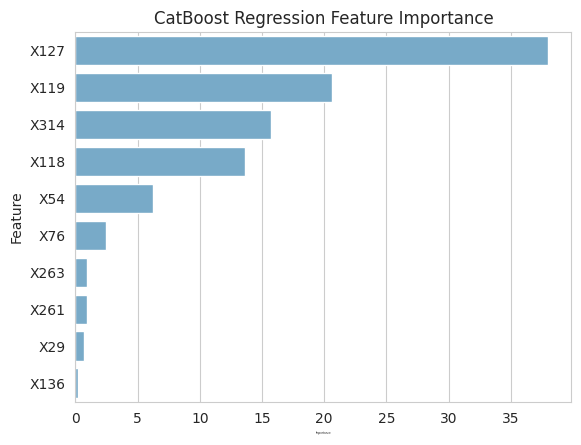

In [20]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = cat_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('CatBoost Regression Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot

Permutation explainer: 201it [00:21,  5.82it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


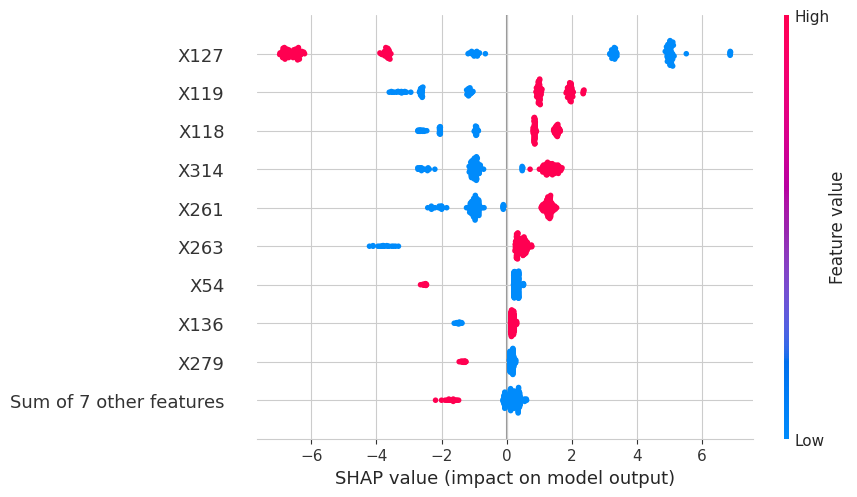

In [21]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(cat_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

Train with full training dataset

In [53]:
# Fit the model on the training data
cat_reg.fit(train[x_train.columns], y, verbose = False)
cat_df = create_sample_sub(cat_reg, train, test, y)
cat_df.head(n = 5)

,ID,y
0,1,78.038438
1,2,93.958056
2,3,78.038438
3,4,78.038438
4,5,112.905300


5) Ensemble Learning of XGBoost and Catboost

Average method

In [65]:
# Generate predictions from both models
xgb_preds = xgb_reg.predict(test[x_train.columns])
catboost_preds = cat_reg.predict(test[x_train.columns])

# Combine predictions using averaging
ensemble_preds = (xgb_preds + catboost_preds) / 2
# Create a new DataFrame
ensemble_x_c = pd.DataFrame()
ensemble_x_c['ID'] = test['ID']
ensemble_x_c['y'] = ensemble_preds
ensemble_x_c.head(n = 5)

,ID,y
0,1,78.038430
1,2,93.958066
2,3,78.038430
3,4,78.038430
4,5,112.905287


Stacking model

In [74]:
from sklearn.model_selection import train_test_split
# Split the training data into subsets
x_train1, x_train2, y_train1, y_train2 = train_test_split(train[x_train.columns],
                                                          y,
                                                          test_size=0.5,
                                                          random_state=42)

# Train base models (XGBoost and CatBoost) on different subsets
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train1, y_train1)

catboost_model = CatBoostRegressor(verbose = False)
catboost_model.fit(x_train2, y_train2)

# Generate predictions for the original training data using the base models
xgb_preds = xgb_model.predict(train[x_train.columns])
catboost_preds = catboost_model.predict(train[x_train.columns])

# Concatenate the predictions with the original features to create a new feature matrix
new_train_features = np.column_stack((train[x_train.columns],
                                      xgb_preds, catboost_preds))

# Train the meta-model (XGBoost) on the new feature matrix using the original target variable
meta_model = CatBoostRegressor(verbose = False)
meta_model.fit(new_train_features, y)

# Generate predictions on the test data using the base models
xgb_test_preds = xgb_model.predict(test[x_train.columns])
catboost_test_preds = catboost_model.predict(test[x_train.columns])

# Concatenate the test predictions with the original features
new_test_features = np.column_stack((test[x_train.columns],
                                     xgb_test_preds,
                                     catboost_test_preds))

# Make predictions on the test data using the meta-model
ensemble_preds1 = meta_model.predict(new_test_features)

# Create a new DataFrame
ensemble_x_c_stack = pd.DataFrame()
ensemble_x_c_stack['ID'] = test['ID']
ensemble_x_c_stack['y'] = ensemble_preds1
ensemble_x_c_stack.head(n = 5)

,ID,y
0,1,78.038524
1,2,93.958055
2,3,78.038524
3,4,78.038524
4,5,112.905299


Export sample submission folders for each of the model

In [62]:
import os

In [75]:
rf_df.to_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/RandomForest_submission.csv', index=False)
lgb_df.to_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/LGBM_submission.csv', index=False)
xgb_df.to_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/XGBoost_submission.csv', index=False)
cat_df.to_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/catboost_submission.csv', index=False)
ensemble_x_c.to_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/ensemble_xgboost_catboost_submission.csv', index=False)
ensemble_x_c_stack.to_csv('/content/drive/MyDrive/Project/Mercedes-Greener-Manufact/Datasets/ensemble_xgboost_catboost_stack_submission.csv', index=False)